In [323]:
import mne
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA

from sklearn.metrics import confusion_matrix
import itertools

import os

In [324]:
#seach all folders and the set files in each folder



In [325]:
"""
Filter Epoch data for visual language vs visual non-language
Visual Language stim code : VVLL
Visual non-language stim code: VVNN
"""

languageStimCodes = ["VVLL"]
nonLanguageStimCodes = ["VVNN"]

stim_combinations = {
    (5,6,4): "AALL",
    (17,18,16) :"AALL",
    
    (11,6,10):"AALN",
    (23,18,22):"AALN",
    
    (5,12,4) :"AANL",
    (17,24,16):"AANL",
    
    (11,12,10) : "AANN",
    (23,24,22): "AANN",
    
    (2,6,1):"AVLL",
    (14,18,13):"AVLL",
    
    (8,12,7):"AVNN",
    (20,24,19):"AVNN",
    
    (5,3,4) :"VALL",
    (17,15,16):"VALL",
    
    (11,9,10) :"VANN",
    (23,21,22):"VANN",
    
    (2,3,1) :"VVLL",
    (14,15,13):"VVLL",
    
    (8,3,7):"VVLN",
    (20,15,19):"VVLN",
    
    (2,9,1) :"VVNL",
    (14,21,13):"VVNL",
    
    (8,9,7) :"VVNN",
    (20,21,19):"VVNN",
    
    (14,21,4):"whatever"
    
}

def find_stim_combo(epochObj,stimCombos1,stimCombos2):
    events = epochObj.events
    numOfEvents = epoch.events.shape[0]
    events_new = []
    combo = []
    
    for i in range(0,numOfEvents-3,3):
        temp = []
        #print('three')
        for h in range(i,i+3):
            #print(events[h][-1])
            combo.append(events[h])
            
        combo_tuple = (combo[0][-1],combo[1][-1],combo[2][-1])   
        #print(combo_tuple)
        for k in stimCombos1:
            if k == stim_combinations[combo_tuple]:
                #print("found visual")
                combo[0][-1] = 100
                combo[1][-1] = 100
                combo[2][-1] = 100
                temp.append(combo[0])
                temp.append(combo[1])
                temp.append(combo[2])
        
        for j in stimCombos2:
            if j == stim_combinations[combo_tuple]:
                #print("found audio")
                combo[0][-1] = 200
                combo[1][-1] = 200
                combo[2][-1] = 200
                temp.append(combo[0])
                temp.append(combo[1])
                temp.append(combo[2])        
        
        for p in temp:
            events_new.append(p)
        combo = []
    return events_new


In [331]:
#method to classify takes features data and corresponding-events array
#prints classifiation report
def classifier(features,target):
    clf = RandomForestClassifier(n_estimators=100,random_state=0)
    #clf = LogisticRegression()
    cv = StratifiedKFold(n_splits=5,shuffle=True)
    scores = []
    
    for train,test in cv.split(features,target):
        preds = []
        X_train = features[train]; y_train = target[train] 
        X_test = features[test];   y_test = target[test]

    

        twoD_X_train = Vectorizer().fit_transform(X_train)
        #print('original shape of training set',(X_train.shape))
        #print('Vectorized shape of training set',(twoD_X_train.shape))
        clf.fit(twoD_X_train,y_train)

        #print(clf.feature_importances_.shape)
        twoD_X_test = Vectorizer().fit_transform(X_test)
        #print('original shape of test set',(X_test.shape))
        #print('Vectorized shape of test set',(twoD_X_test.shape))
        
        preds.append(clf.predict(twoD_X_test))
        #print('shape of y_test is: ',np.array(y_test).shape)
        #print(np.array(preds).shape)
        d = np.transpose(preds).ravel()
        #print('shape of pred is: ',d.shape)
        
        print('Accuracy on training set {:.3f}'.format(clf.score(twoD_X_train,y_train)))
        print('Accuracy on test set {:.3f}'.format(clf.score(twoD_X_test,y_test)))
        scores.append(clf.score(twoD_X_test,y_test))
        
        target_names = ['lang', 'non-lang']

        
        report = classification_report(y_test, d, target_names=target_names)
        print(report)
        
    
    
    return np.mean(scores)

In [332]:
"""
Fits model to data and finds the feature importances
Finds the top 20 features importances and plots them to the head map.
"""
def importantChannelFinder(features,target):
    forest = RandomForestClassifier(n_estimators=100,random_state=0)
    #clf = LogisticRegression()
    cv = StratifiedKFold(n_splits=10,shuffle=True)
    scores = []
    """creating channel dictionary"""
    ch_dict = {}
    for i in range(0,125):
        ch_dict[i] = 0
    #print(ch_dict)    
    for train,test in cv.split(features,target):
        preds = []
        X_train = features[train]; y_train = target[train] 
        X_test = features[test];   y_test = target[test]

    

        twoD_X_train = Vectorizer().fit_transform(X_train)
        forest.fit(twoD_X_train,y_train)

        """manipulate array to 125 features"""
        impt = []
        for e in forest.feature_importances_:
            impt.append(e)

        #print("shape of important feat array: ",np.array(impt).shape)
        temp = []
        time = binary_epoch.get_data().shape[2]
        channel_time = binary_epoch.get_data().shape[1] * binary_epoch.get_data().shape[2]
        for i in range(0,channel_time,time):
            #print(i)
            hold = []
            for j in range(i,i+time):
                hold.append(impt[j])

            temp.append(np.sum(hold))    

        #print("new shape of important feat array: ",np.array(temp).shape) 
        a = np.array(temp)
        ind = np.argpartition(a, -20)[-20:]  #top ten
        print("top twenty channels: ",ind)
        print('top twenty channels importances: ',a[ind])
        
        for i in ind:
            value = ch_dict[i]
            ch_dict[i] = value + 1 
        
        
            
            
#         twoD_X_test = Vectorizer().fit_transform(X_test)
        
        
#         preds.append(forest.predict(twoD_X_test))
        
#         d = np.transpose(preds).ravel()
        
#         scores.append(forest.score(twoD_X_test,y_test))
        
#         target_names = ['lang', 'non-lang']
#         report = classification_report(y_test, d, target_names=target_names)
        #print(report)
        
    for kk in ch_dict:
        v = master[kk]
        master[kk] = v + ch_dict[kk]
    
    hold = [] #keys
    hold2 = [] #values
    for key in ch_dict:
        if ch_dict[key] >= 5:
            hold.append(key)
            hold2.append(ch_dict[key])
    print('importanct channels shape: ',np.array(hold).shape)        
    plt.bar(hold,hold2) 
    hold3 = []
    for k in hold:
        if binary_epoch.ch_names[k] != 'STI 014':
            hold3.append(binary_epoch.ch_names[k])

    print(hold3)
    """
    Plot sensors
    """

    montage = mne.channels.read_montage('ANT_DukeWaveGuard_128_electrode_montages_updated_V4') 
    epoch.set_montage(montage)  
    epoch.plot_sensors(show_names=hold3)
    return np.mean(scores)

In [333]:
#path = "/Users/tarekulislam/Desktop/seniorprojecteeg/Tarekul_Workspace/capstone2/20140306_1133-epo.fif"
#path2 = '/Volumes/flash64/OneDrive_1_11-28-2018/20140205_1114_epo.fif'


def do(epoch):
    #epoch = mne.read_epochs(p,preload=True)
    epoch.drop_channels(ch_names=[ 'LL4', 'L12'])
    epoch.drop_channels(ch_names=[ 'Nasium', 'VEOG'])
    
    epoch_copy = epoch.copy()
    find_stim_combo(epoch_copy,languageStimCodes,nonLanguageStimCodes)
    binary_epoch = epoch_copy[(epoch_copy.events[:,-1]==100) | (epoch_copy.events[:,-1]==200)].copy()
    binary_epoch.get_data().shape
    
    """
    Classify filtered data and check results
    """
    features = binary_epoch.get_data()
    target = binary_epoch.events[:,-1]
    
    print("mean classification score", classifier(features,target))
    
    importantChannelFinder(features,target)
    
    """
    Plot Band topomaps
    """
    
    bands = [(0, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'),
    (12, 30, 'Beta'), (30, 45, 'Gamma')]
    binary_epoch.plot_psd_topomap(bands = bands)
    

In [334]:
def SubjFolderSearch(path):
    subjFolders = os.listdir(path)
    AllFiles = []
    for i in subjFolders:
        if '.DS_Store' not in i:
            AllFiles.append(os.path.join(path,i))
    
    
    return AllFiles

Reading /Volumes/flash64/fifFiles/20131216_1310_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
1759 matching events found
Applying baseline correction (mode: mean)
1759 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Reading /Volumes/flash64/fifFiles/20131216_1441_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
1753 matching events found
Applying baseline correction (mode: mean)
1753 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Reading /Volumes/flash64/fifFiles/20140205_1114_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
1908 matching events found
Applying baseline correction (mode: mean)
1908 matching even

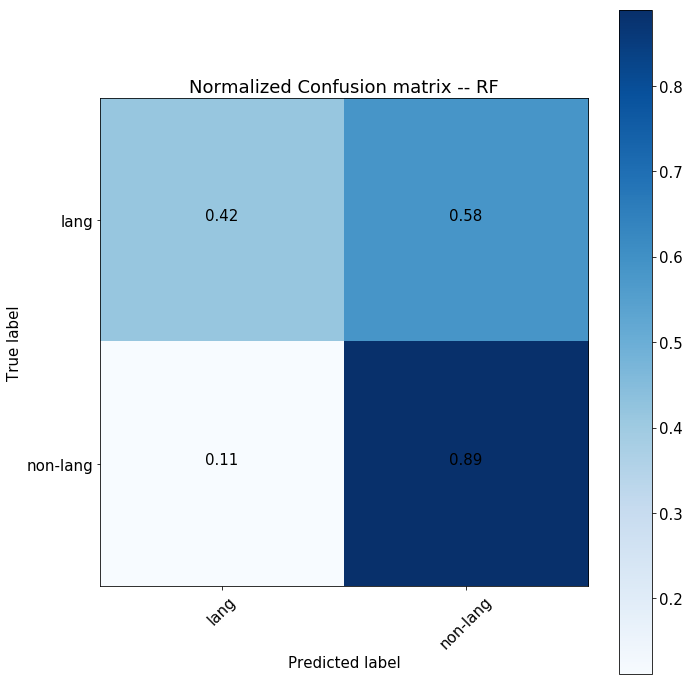

             precision    recall  f1-score   support

       lang       0.71      0.42      0.53        24
   non-lang       0.70      0.89      0.78        36

avg / total       0.70      0.70      0.68        60

Accuracy on training set 1.000
Accuracy on test set 0.767


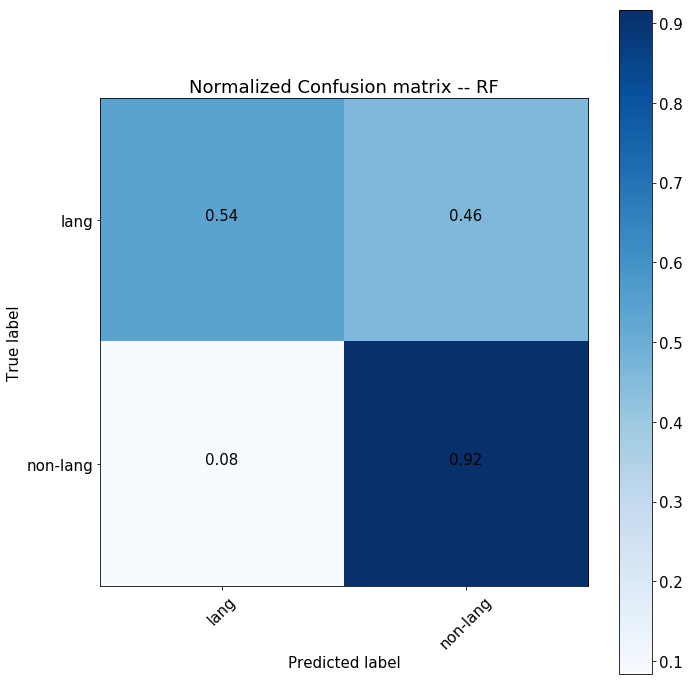

             precision    recall  f1-score   support

       lang       0.81      0.54      0.65        24
   non-lang       0.75      0.92      0.83        36

avg / total       0.78      0.77      0.76        60

Accuracy on training set 1.000
Accuracy on test set 0.644


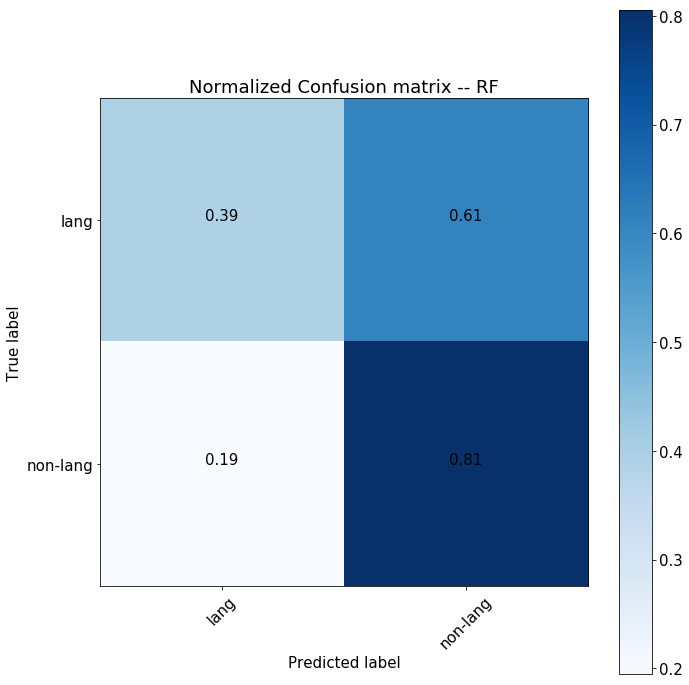

             precision    recall  f1-score   support

       lang       0.56      0.39      0.46        23
   non-lang       0.67      0.81      0.73        36

avg / total       0.63      0.64      0.63        59

Accuracy on training set 1.000
Accuracy on test set 0.746


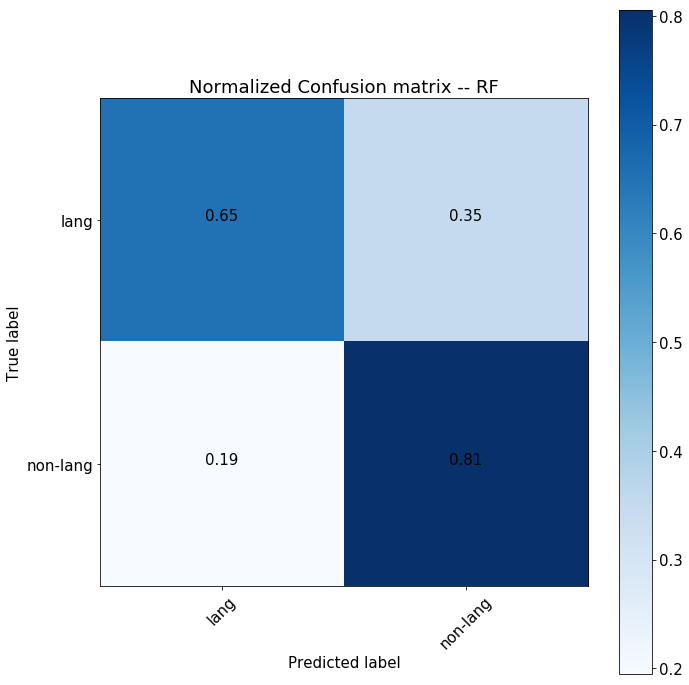

             precision    recall  f1-score   support

       lang       0.68      0.65      0.67        23
   non-lang       0.78      0.81      0.79        36

avg / total       0.74      0.75      0.74        59

Accuracy on training set 1.000
Accuracy on test set 0.746


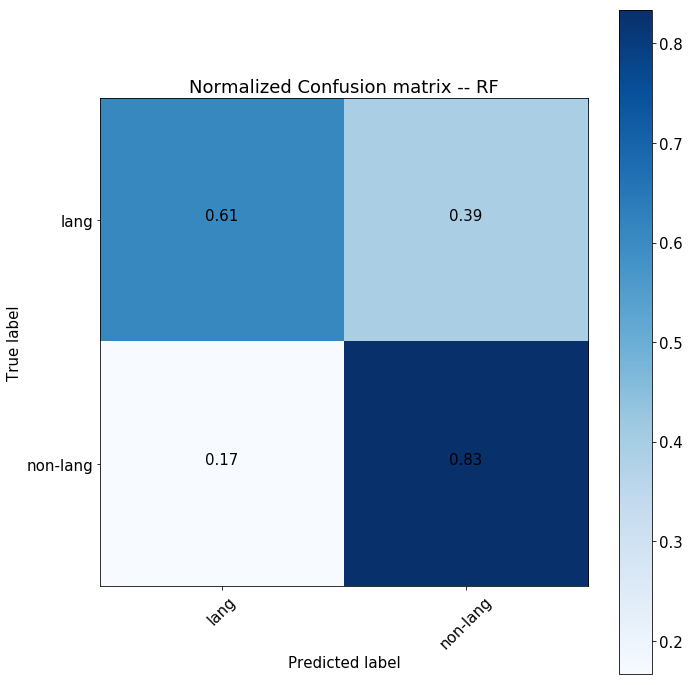

             precision    recall  f1-score   support

       lang       0.70      0.61      0.65        23
   non-lang       0.77      0.83      0.80        36

avg / total       0.74      0.75      0.74        59

mean classification score 0.7204519774011299
top twenty channels:  [ 17 105   5  42  25  34  43  76  75  50  84 103  85  21  86 120  57  66
  95  30]
top twenty channels importances:  [0.01084583 0.01096075 0.01152153 0.01193618 0.01204191 0.01219055
 0.01234131 0.01597561 0.02114435 0.01240367 0.01928387 0.01358216
 0.01848869 0.0143328  0.01864702 0.01435279 0.01420829 0.01602275
 0.02296765 0.02128545]
top twenty channels:  [ 91 105 103  53 120 119  74  21  76  94  95  25  86  85  66  57  84  30
  75  33]
top twenty channels importances:  [0.01054987 0.01222035 0.01123767 0.01069265 0.01142745 0.01195471
 0.01279309 0.01289386 0.01563132 0.01335197 0.02112166 0.01429235
 0.01937608 0.01501066 0.01700872 0.01669094 0.02271169 0.01646047
 0.02596314 0.01322232]
top twenty c

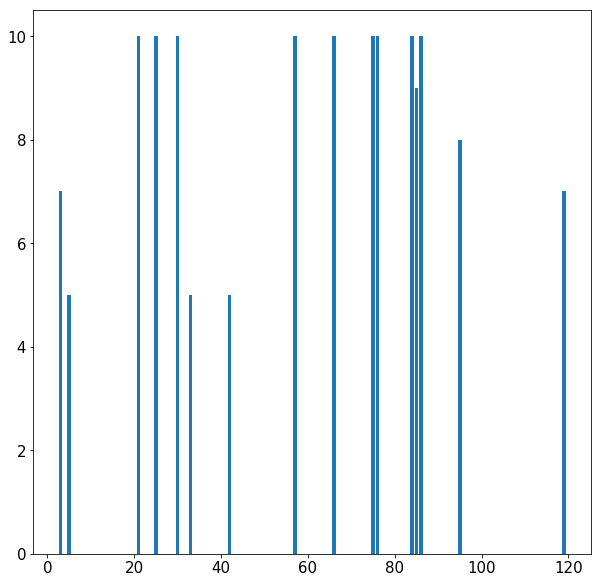

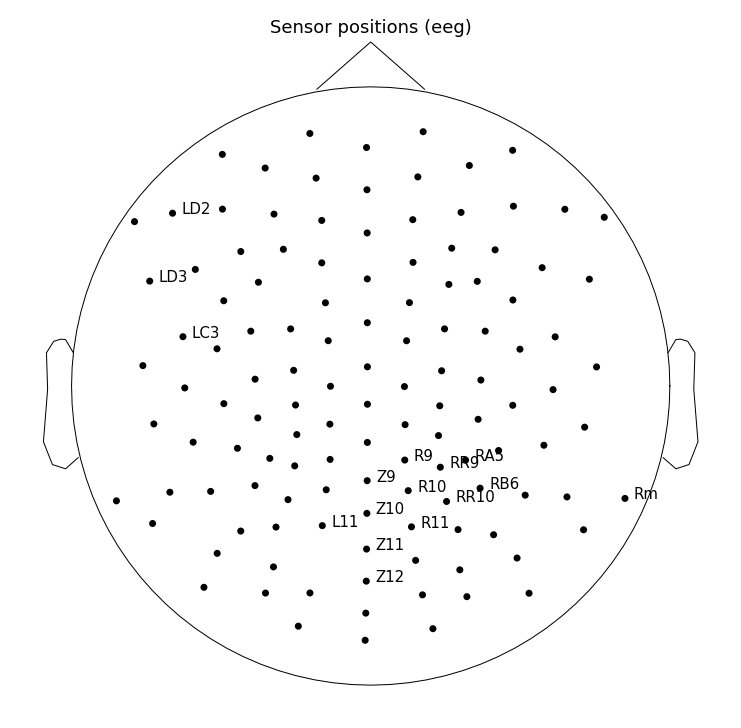

Reading /Volumes/flash64/fifFiles/20140205_1230_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1977 matching events found
Applying baseline correction (mode: mean)
1977 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Accuracy on training set 1.000
Accuracy on test set 0.812


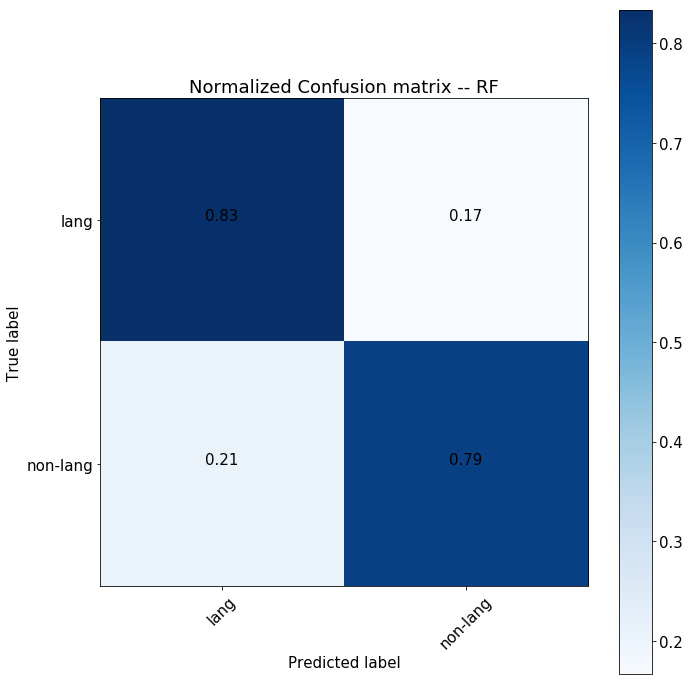

             precision    recall  f1-score   support

       lang       0.80      0.83      0.82        24
   non-lang       0.83      0.79      0.81        24

avg / total       0.81      0.81      0.81        48

Accuracy on training set 1.000
Accuracy on test set 0.542


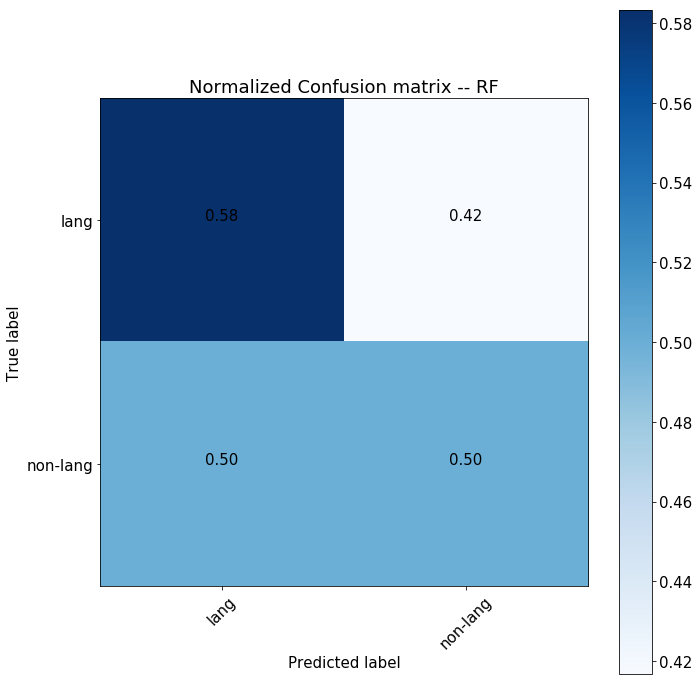

             precision    recall  f1-score   support

       lang       0.54      0.58      0.56        24
   non-lang       0.55      0.50      0.52        24

avg / total       0.54      0.54      0.54        48

Accuracy on training set 1.000
Accuracy on test set 0.708


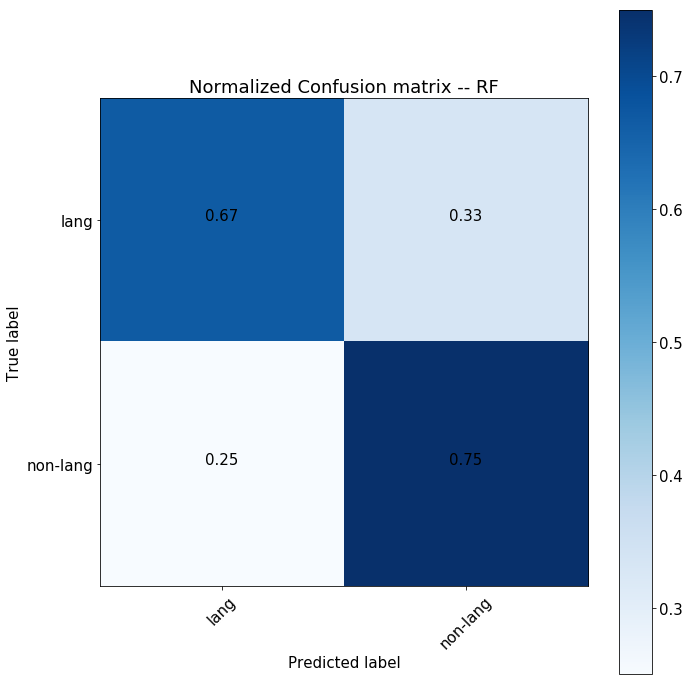

             precision    recall  f1-score   support

       lang       0.73      0.67      0.70        24
   non-lang       0.69      0.75      0.72        24

avg / total       0.71      0.71      0.71        48

Accuracy on training set 1.000
Accuracy on test set 0.750


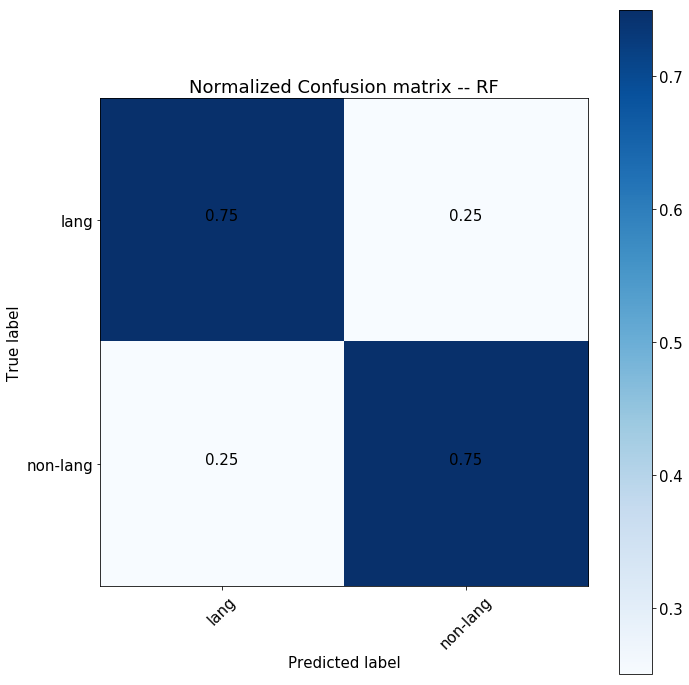

             precision    recall  f1-score   support

       lang       0.75      0.75      0.75        24
   non-lang       0.75      0.75      0.75        24

avg / total       0.75      0.75      0.75        48

Accuracy on training set 1.000
Accuracy on test set 0.542


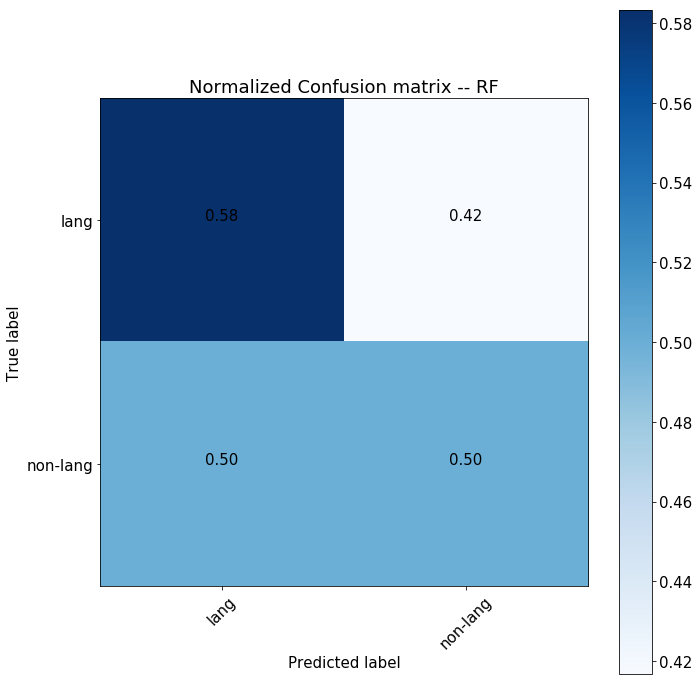

             precision    recall  f1-score   support

       lang       0.54      0.58      0.56        24
   non-lang       0.55      0.50      0.52        24

avg / total       0.54      0.54      0.54        48

mean classification score 0.6708333333333333
top twenty channels:  [112  12 104  21   5  73  16 102  76  94  72 101 117  25  57  84  83 122
  81  82]
top twenty channels importances:  [0.01123469 0.01184318 0.01188572 0.01133033 0.0120454  0.01189091
 0.01230194 0.01241841 0.01266266 0.01645321 0.0130308  0.01339608
 0.01374098 0.01476894 0.01515521 0.01581063 0.01306871 0.01883921
 0.01365362 0.01358442]
top twenty channels:  [101   6  48  35  20  95  21 112  11   5  71  28  69  85  86  75 121  25
  77  84]
top twenty channels importances:  [0.01153753 0.0115381  0.0122931  0.01158607 0.01360161 0.01332518
 0.01332743 0.01224808 0.01239146 0.01249771 0.01216399 0.01296184
 0.01265817 0.01377532 0.01435713 0.02483913 0.01535027 0.01595612
 0.01394893 0.01894159]
top twenty c

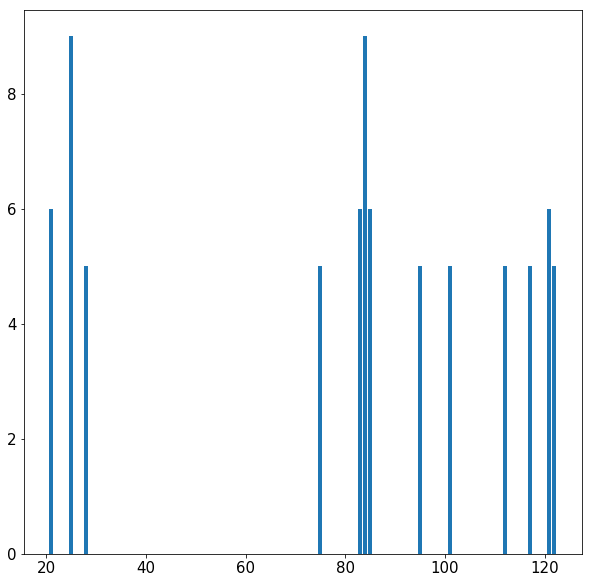

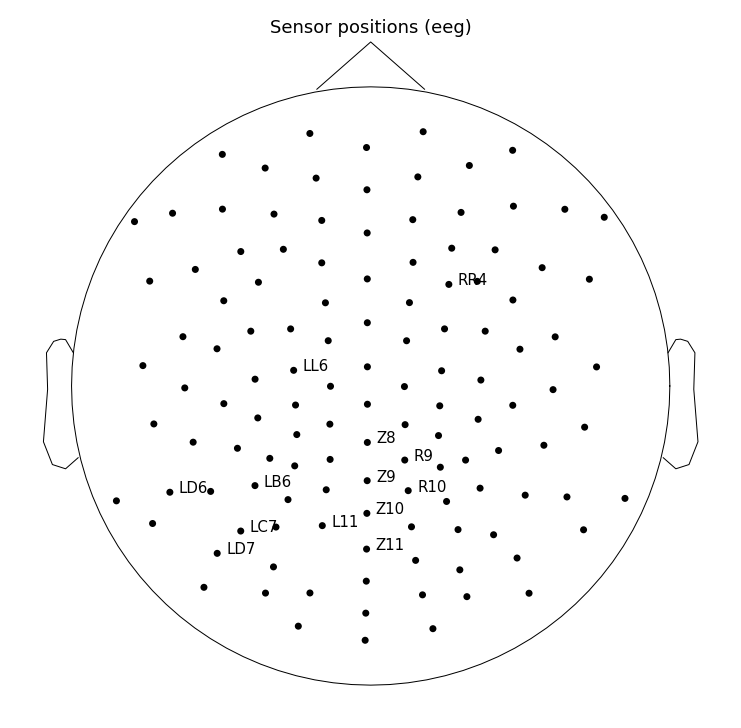

Reading /Volumes/flash64/fifFiles/20140319_1043_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2148 matching events found
Applying baseline correction (mode: mean)
2148 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Accuracy on training set 1.000
Accuracy on test set 0.917


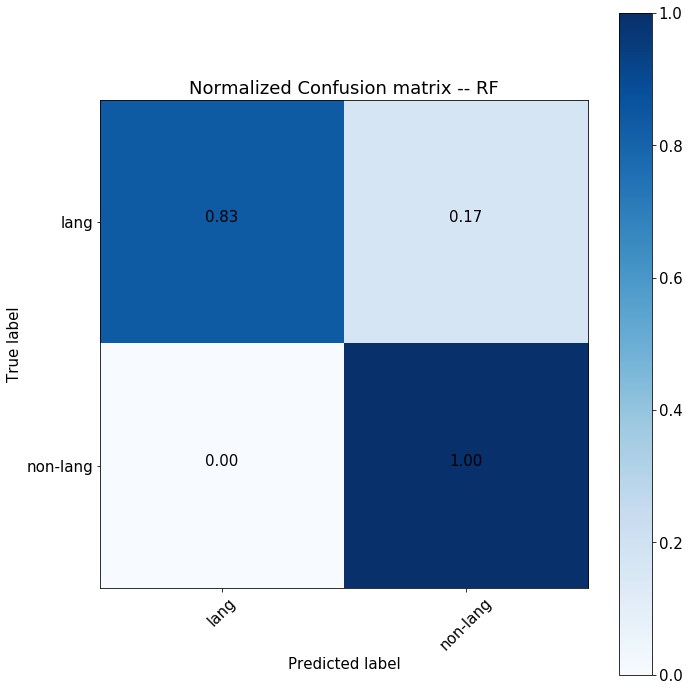

             precision    recall  f1-score   support

       lang       1.00      0.83      0.91        12
   non-lang       0.86      1.00      0.92        12

avg / total       0.93      0.92      0.92        24

Accuracy on training set 1.000
Accuracy on test set 1.000


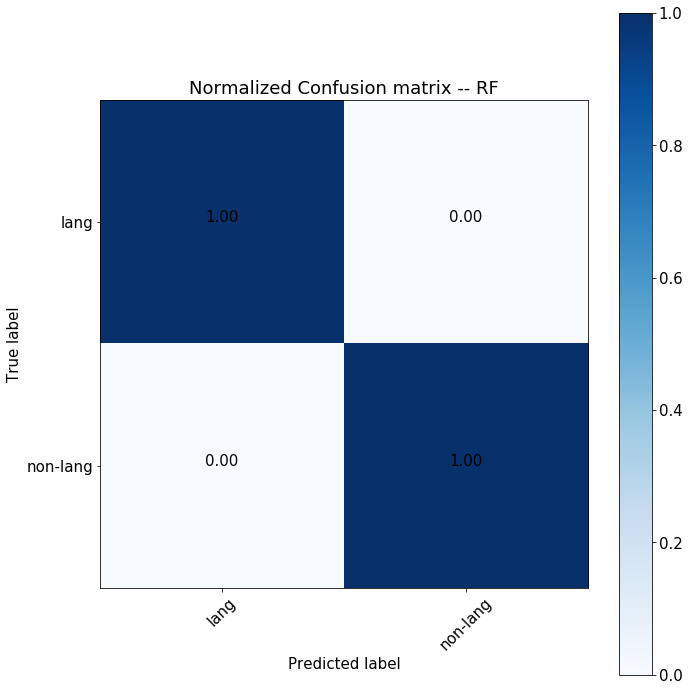

             precision    recall  f1-score   support

       lang       1.00      1.00      1.00        12
   non-lang       1.00      1.00      1.00        12

avg / total       1.00      1.00      1.00        24

Accuracy on training set 1.000
Accuracy on test set 0.833


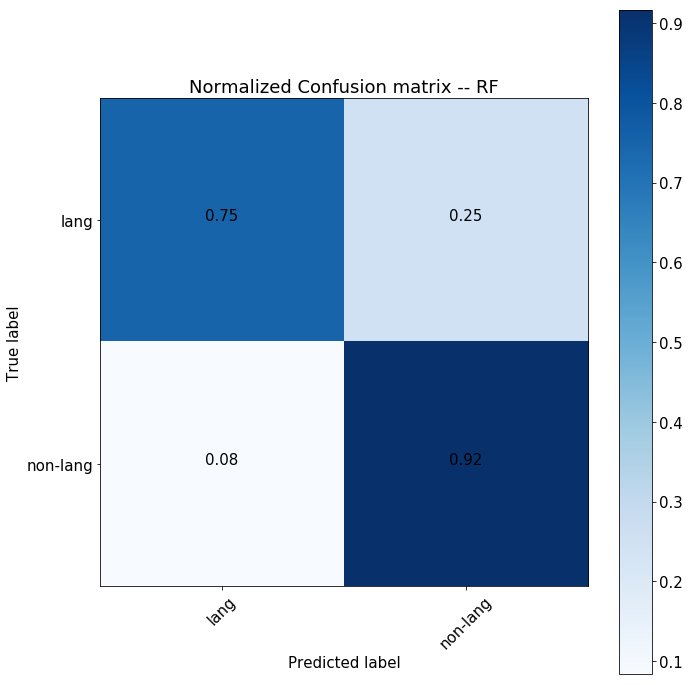

             precision    recall  f1-score   support

       lang       0.90      0.75      0.82        12
   non-lang       0.79      0.92      0.85        12

avg / total       0.84      0.83      0.83        24

Accuracy on training set 1.000
Accuracy on test set 0.875


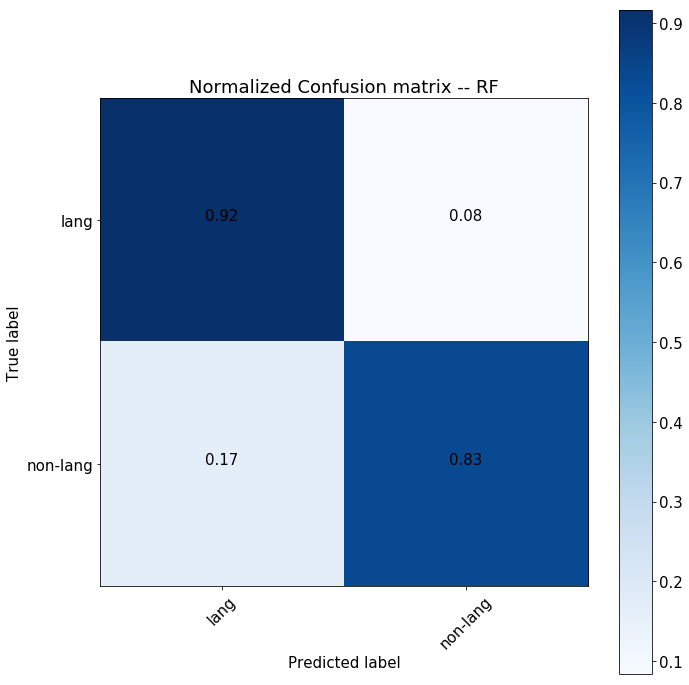

             precision    recall  f1-score   support

       lang       0.85      0.92      0.88        12
   non-lang       0.91      0.83      0.87        12

avg / total       0.88      0.88      0.87        24

Accuracy on training set 1.000
Accuracy on test set 0.917


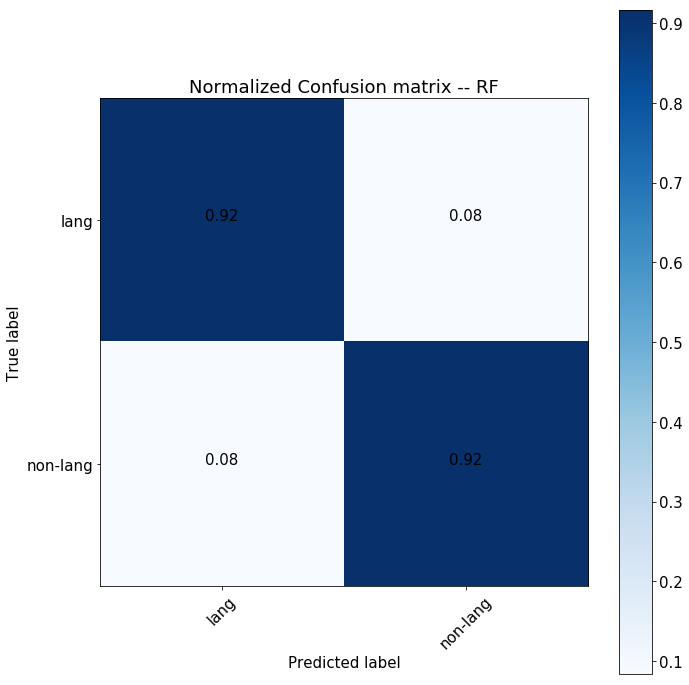

             precision    recall  f1-score   support

       lang       0.92      0.92      0.92        12
   non-lang       0.92      0.92      0.92        12

avg / total       0.92      0.92      0.92        24

mean classification score 0.9083333333333334
top twenty channels:  [35 64 49 47 46 61 50 40 39 38 51 36 52 54 32 55 56 24 58 45]
top twenty channels importances:  [0.01381345 0.01381453 0.02434674 0.01955278 0.03130596 0.01607254
 0.02216771 0.04407006 0.05649835 0.01457423 0.02139662 0.02689275
 0.03967658 0.09591601 0.04075847 0.07930624 0.02215389 0.01514384
 0.05477088 0.0315613 ]
top twenty channels:  [63 59 61 38 47 35 49 52 50 54 55 46 45 40 39 56 36 58 32 51]
top twenty channels importances:  [0.01334446 0.02072653 0.01597397 0.02350655 0.02162287 0.0203582
 0.02412169 0.03299325 0.04830306 0.07874905 0.11450389 0.04480128
 0.0473638  0.03833091 0.04267825 0.03028217 0.06109842 0.03736617
 0.02814062 0.02587123]
top twenty channels:  [72 62 54 52 55 50 49 47 46 45 56

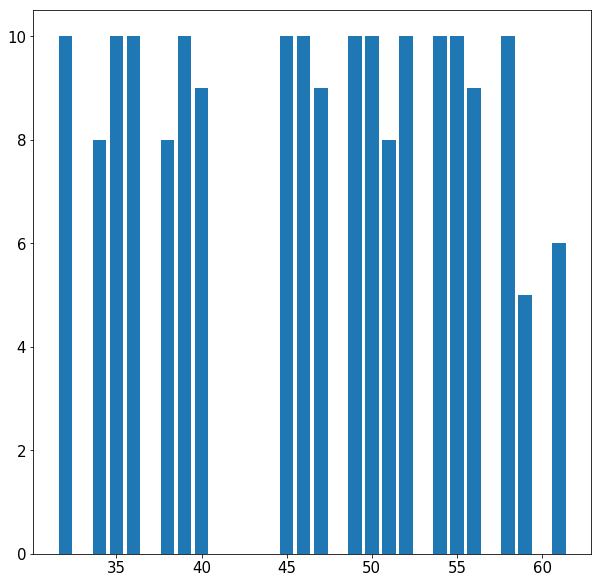

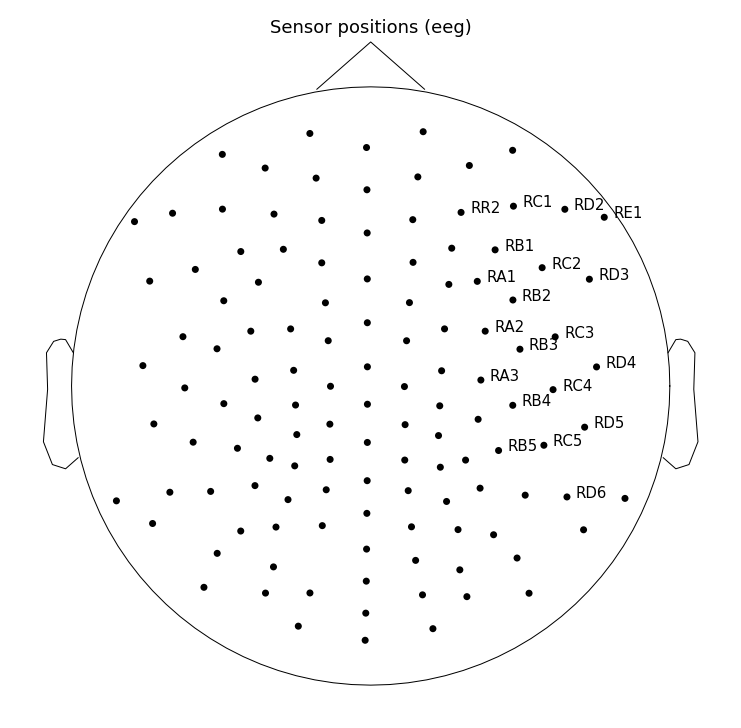

Reading /Volumes/flash64/fifFiles/20140319_1342_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1657 matching events found
Applying baseline correction (mode: mean)
1657 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Reading /Volumes/flash64/fifFiles/20140424_1002_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available


KeyboardInterrupt: 

In [335]:
path = '/Volumes/flash64/fifFiles'
AllSetFiles = SubjFolderSearch(path)
#print(AllSetFiles)

master = {}
for i in range(0,125):
    master[i] = 0
    
def find_mod3files(fileArray):
    #good_paths = []
    for file in fileArray:
        epo = mne.read_epochs(file)
        if epo.get_data().shape[0] % 3 == 0:
            do(epo)

            


find_mod3files(AllSetFiles)
h1 = []
h2 = []
for k in master:
    h1.append(k)
    h2.append(master[k])
    
plt.bar(h1,h2)    

In [186]:
"""
pipeling for converting data from 3D to 2D using vectorizer and
RandomForest for classification 
"""


#clf = make_pipeline(Vectorizer(),StandardScaler(), RandomForestClassifier(n_estimators=100, max_depth=2,max_features='sqrt'))

def classifier(features,target):
    clf = RandomForestClassifier(n_estimators=100,random_state=0)
    cv = StratifiedKFold(n_splits=5,shuffle=True)
    scores = []
    preds = []
    for train,test in cv.split(features,target):
        X_train = features[train]; y_train = target[train] 
        X_test = features[test];   y_test = target[test]

    

        aa = Vectorizer().fit_transform(X_train)
        print('original shape of training set',(X_train.shape))
        print('Vectorized shape of training set',(aa.shape))
        clf.fit(aa,y_train)

        print(clf.feature_importances_.shape)
        bb = Vectorizer().fit_transform(X_test)
        preds.append(clf.predict(bb))
        
        print('Accuracy on training set {:.3f}'.format(clf.score(aa,y_train)))
        print('Accuracy on training set {:.3f}'.format(clf.score(bb,y_test)))
        scores.append(clf.score(bb,y_test))
        
    target_names = ['lang', 'non-lang']
    preds = np.concatenate(preds)
    report = classification_report(target, preds, target_names=target_names)
    print(report)
    
    # Normalized confusion matrix
    cm = confusion_matrix(target, preds)
    cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    fmt = '.2f'
    for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
            plt.text(j, i, format(cm_normalized[i, j],fmt),
                     horizontalalignment="center",
                     color="black")
    tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return np.mean(scores)
    
    

original shape of training set (192, 125, 500)
Vectorized shape of training set (192, 62500)
(62500,)
Accuracy on training set 1.000
Accuracy on training set 0.708
original shape of training set (192, 125, 500)
Vectorized shape of training set (192, 62500)
(62500,)
Accuracy on training set 1.000
Accuracy on training set 0.750
original shape of training set (192, 125, 500)
Vectorized shape of training set (192, 62500)
(62500,)
Accuracy on training set 1.000
Accuracy on training set 0.729
original shape of training set (192, 125, 500)
Vectorized shape of training set (192, 62500)
(62500,)
Accuracy on training set 1.000
Accuracy on training set 0.771
original shape of training set (192, 125, 500)
Vectorized shape of training set (192, 62500)
(62500,)
Accuracy on training set 1.000
Accuracy on training set 0.771
             precision    recall  f1-score   support

       lang       0.31      0.07      0.11        60
   non-lang       0.75      0.95      0.84       180

avg / total       0

NameError: name 'tight_layout' is not defined

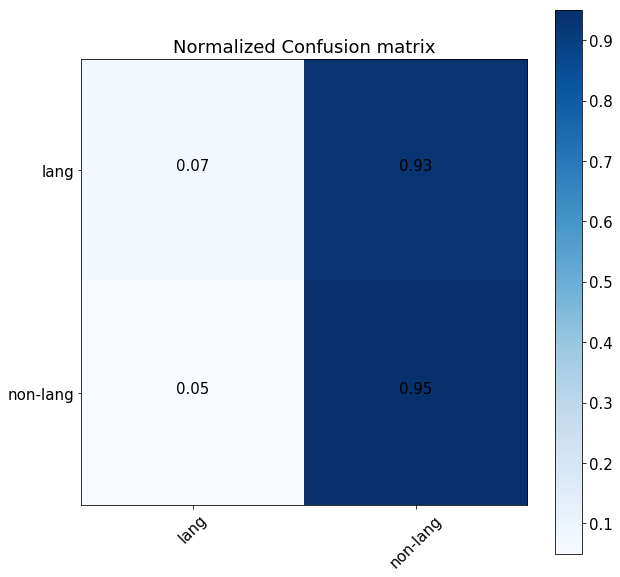

In [192]:
print("mean classification score", classifier(features,target))


In [22]:
import scipy
import pandas as pd
arr = []
for epoch in range(0,240):
    temp = []
    for channel in features[epoch]:
        hold = []
        var1 = np.mean(channel)
        skew1 = scipy.stats.skew(channel)
        kurtosis1 = scipy.stats.kurtosis(channel)
        hold.append(var1)
        hold.append(skew1)
        hold.append(kurtosis1)
        temp.append(hold)
    arr.append(temp)
    temp = []
    
arr=np.array(arr)
    
    
print(arr.shape)

(240, 125, 3)


In [23]:
print("mean classification score", classifier(arr,target))



original shape of training set (192, 125, 3)
Vectorized shape of training set (192, 375)
(375,)
Accuracy on training set 1.000
Accuracy on training set 0.750
original shape of training set (192, 125, 3)
Vectorized shape of training set (192, 375)
(375,)
Accuracy on training set 1.000
Accuracy on training set 0.792
original shape of training set (192, 125, 3)
Vectorized shape of training set (192, 375)
(375,)
Accuracy on training set 1.000
Accuracy on training set 0.854
original shape of training set (192, 125, 3)
Vectorized shape of training set (192, 375)
(375,)
Accuracy on training set 1.000
Accuracy on training set 0.854
original shape of training set (192, 125, 3)
Vectorized shape of training set (192, 375)
(375,)
Accuracy on training set 1.000
Accuracy on training set 0.896
mean classification score 0.8291666666666666


In [160]:
def findImportantFeatures(feature_data,target):
    X_train, X_test, y_train, y_test = train_test_split(feature_data, target, random_state=0)

    forest = RandomForestClassifier(n_estimators=100, random_state=0)
    twoDimTrainData = Vectorizer().fit_transform(X_train)
    forest.fit(twoDimTrainData, y_train)
    
    twoDimTestData = Vectorizer().fit_transform(X_test)
    print('Accuracy on the training subset: {:.3f}'.format(forest.score(twoDimTrainData, y_train)))
    print('Accuracy on the test subset: {:.3f}'.format(forest.score(twoDimTestData, y_test)))
    
    print(forest.feature_importances_.shape)
    

    impt = []
    for e in forest.feature_importances_:
        impt.append(e)
    
    print("shape of important feat array: ",np.array(impt).shape)
    temp = []
    
    for i in range(0,375,3):
        #print(i)
        hold = []
        for j in range(i,i+3):
            hold.append(impt[j])
            
        temp.append(np.mean(hold))    
            
    print("new shape of important feat array: ",np.array(temp).shape)    
    
#     n_features = feature_data.shape[1]
#     print("n_features =  ",n_features)
#     plt.barh(range(n_features), temp, align='center')
#     #plt.yticks(np.arange(n_features))
#     plt.xlabel('Feature Importance')
#     plt.ylabel('Feature')
#     plt.show()
    
    ch_names = []
    four_channel_importances = []
    maxx = np.max(temp)
    print(maxx)
    print(temp.index(maxx))
    print(binary_epoch.ch_names[temp.index(maxx)])
    
    
    temp2 = temp.copy()
    temp2.remove(maxx)
            
    maxx2=np.max(temp2)
    print(maxx2)
    print(temp.index(maxx2))
    print(binary_epoch.ch_names[temp.index(maxx2)])
    
    temp3 = temp2.copy()
    temp3.remove(maxx2)
            
    maxx3=np.max(temp3)
    print(maxx3)
    print(temp.index(maxx3))
    print(binary_epoch.ch_names[temp.index(maxx3)])
    
    temp4 = temp3.copy()
    temp4.remove(maxx3)
            
    maxx4=np.max(temp4)
    print(maxx4)
    print(temp.index(maxx4))
    print(binary_epoch.ch_names[temp.index(maxx4)])
      
    ch_names.append(binary_epoch.ch_names[temp.index(maxx)])
    ch_names.append(binary_epoch.ch_names[temp.index(maxx2)])
    ch_names.append(binary_epoch.ch_names[temp.index(maxx3)])
    ch_names.append(binary_epoch.ch_names[temp.index(maxx4)])
    
    four_channel_importances.append(maxx)
    four_channel_importances.append(maxx2)
    four_channel_importances.append(maxx3)
    four_channel_importances.append(maxx4)
    
    plt.bar(ch_names,four_channel_importances)
    plt.xticks((binary_epoch.ch_names[temp.index(maxx)]),(binary_epoch.ch_names[temp.index(maxx2)])\
              ,(binary_epoch.ch_names[temp.index(maxx3)]),(binary_epoch.ch_names[temp.index(maxx4)]))
    
    plt.xlabel('Feature')
    plt.ylabel('Feature Importance')
    plt.show()

Accuracy on the training subset: 1.000
Accuracy on the test subset: 0.883
(375,)
shape of important feat array:  (375,)
new shape of important feat array:  (125,)
0.02867364089637915
111
LB5
0.015155232589967134
54
RB2
0.01066122026973824
10
LA5
0.009378328986807344
112
LB6


TypeError: Illegal number of arguments to xticks

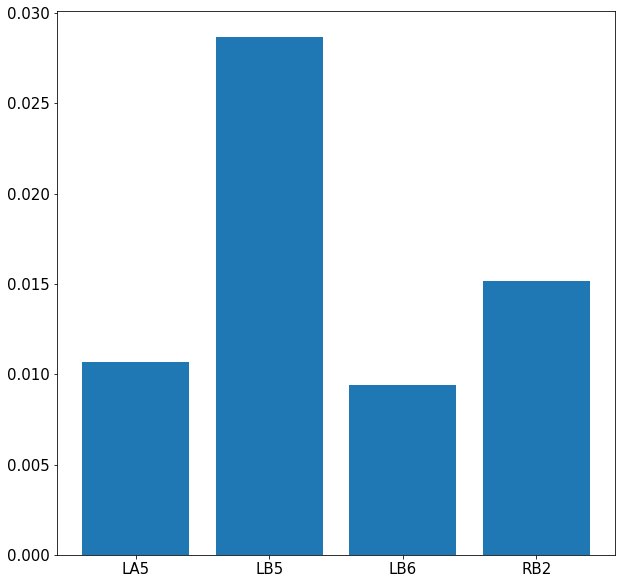

In [161]:
findImportantFeatures(arr,target)

In [101]:
#init pca and fit to data
from sklearn import preprocessing
print(arr.shape)
pca = UnsupervisedSpatialFilter(PCA(), average=False)
pca_data = pca.fit_transform(arr)


(240, 125, 3)


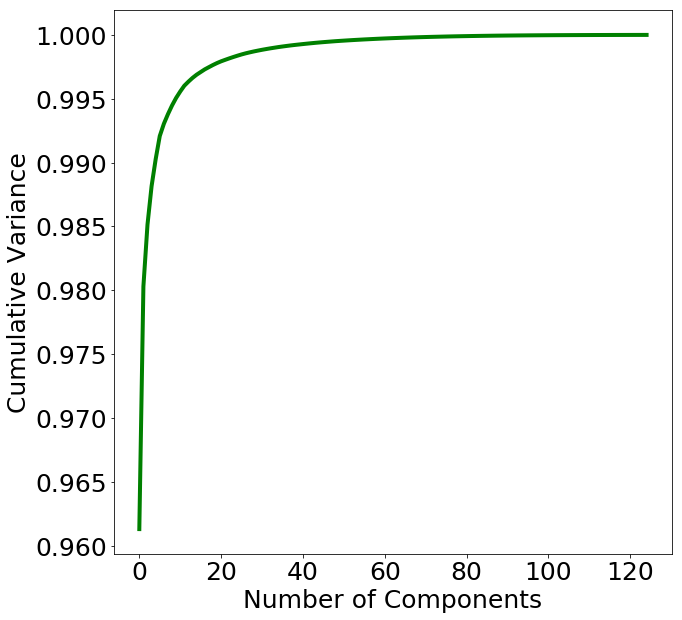

In [102]:
comp_variance = np.cumsum(pca.estimator.explained_variance_ratio_)
plt.plot(comp_variance, linewidth = 4.0, color = 'g')
plt.xlabel('Number of Components', fontsize = 25)
plt.ylabel('Cumulative Variance', fontsize = 25);
plt.xticks(fontsize = 25);
plt.yticks(fontsize = 25);

In [103]:
n_components = np.argwhere(comp_variance > .99)[0]
print(n_components)

[4]


In [165]:
montage2 = mne.channels.read_montage('ANT_DukeWaveGuard_128_electrode_montages_updated_V4',ch_names=['LA5','Lb5','LB6','RB2'])

ValueError: not enough values to unpack (expected 2, got 0)

original shape of training set (192, 4, 3)
Vectorized shape of training set (192, 12)
(12,)
Accuracy on training set 1.000
Accuracy on training set 0.812
original shape of training set (192, 4, 3)
Vectorized shape of training set (192, 12)
(12,)
Accuracy on training set 1.000
Accuracy on training set 0.812
original shape of training set (192, 4, 3)
Vectorized shape of training set (192, 12)
(12,)
Accuracy on training set 1.000
Accuracy on training set 0.896
original shape of training set (192, 4, 3)
Vectorized shape of training set (192, 12)
(12,)
Accuracy on training set 1.000
Accuracy on training set 0.875
original shape of training set (192, 4, 3)
Vectorized shape of training set (192, 12)
(12,)
Accuracy on training set 1.000
Accuracy on training set 0.854
             precision    recall  f1-score   support

       lang       0.26      0.18      0.22        60
   non-lang       0.75      0.83      0.79       180

avg / total       0.63      0.67      0.65       240



NameError: name 'tight_layout' is not defined

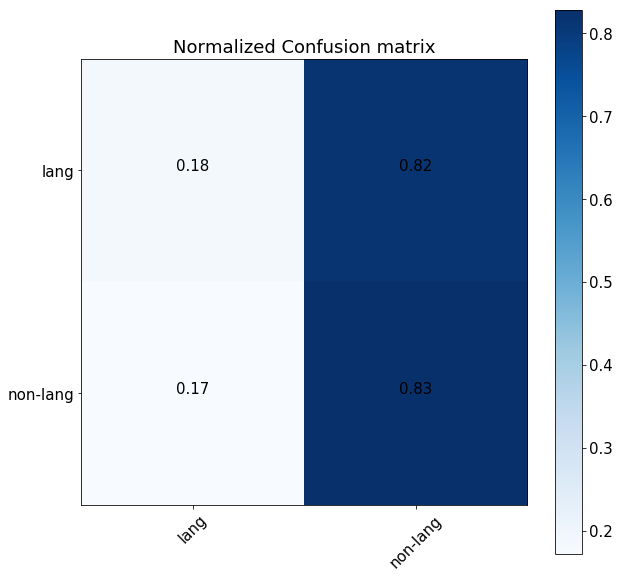

In [191]:
xca = UnsupervisedSpatialFilter(PCA(4), average=False)
xca_data = xca.fit_transform(arr)

classifier(xca_data,target)

In [183]:
target.shape

(240,)